<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"
alt="Rubin Observatory logo, a graphical representation of turning stars into data."> <br><br>
**Description:** Generate plots  and tables summarizing the target fields for the _Rubin Observatory DP1_ paper. <br>
**Authors:** Leanne Guy and Lynne Jones <br>
**Last verified to run:** 2025-05-14 <br>
**LSST Science Pipelines version:** v29.0.0<br>
**Container size:** medium <br>

# DP1 target fields summary

The notebook computes statistics and summaries of all the data in the 7 DP1 fields. It computes a number of parameters to beuse din the paper<br>

Tables produced:<br> 
* Table 2: Summary of the DP1 fields.<br>
* Table X: tracts per fields for the datapriducts section <br>

Figures Produced: <br>
* Figure X: DP1 fields superimposed on survey baseline

## Setup

In [1]:
# Generic python packages
import os
import csv
import requests
import yaml
import numpy as np
import pandas as pd
from pathlib import Path

# LSST Science Pipelines 
from lsst.daf.butler import Butler

# RSP
from lsst.rsp import get_tap_service

# Rubin scheduler
from rubin_scheduler.scheduler.utils import get_current_footprint
import healpy as hp
# At the USDF, access the shared rubin_sim data directory
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# Set rubin publication plot style
from lsst.utils.plotting import publication_plots, get_multiband_plot_colors, stars_color, accent_color
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import colorConverter

# Sky projection
import skyproj
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Install dependencies

In [2]:
# Install the scheduler data if not already done 

# Set the scheduler data path
data_dir = Path('../scheduler_data')
os.environ['RUBIN_SIM_DATA_DIR'] = str(data_dir.resolve())
assert os.getenv('RUBIN_SIM_DATA_DIR') == str(data_dir.resolve())

# Run the install script
%run /opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/bin/scheduler_download_data

  0%|          | 0.00/141M [00:00<?, ?iB/s]

Writing to /sdf/data/rubin/user/lguy/lsst/repos/rtn-095/scheduler_data/scheduler_2023_10_16.tgz


  0%|          | 0.00/85.5M [00:00<?, ?iB/s]

Writing to /sdf/data/rubin/user/lguy/lsst/repos/rtn-095/scheduler_data/site_models_2023_10_02.tgz


  0%|          | 0.00/198M [00:00<?, ?iB/s]

Writing to /sdf/data/rubin/user/lguy/lsst/repos/rtn-095/scheduler_data/skybrightness_pre_2024_11_19.tgz


  0%|          | 0.00/24.4k [00:00<?, ?iB/s]

Writing to /sdf/data/rubin/user/lguy/lsst/repos/rtn-095/scheduler_data/utils_2023_11_02.tgz
Current/updated data versions:
scheduler		scheduler_2023_10_16.tgz
site_models	site_models_2023_10_02.tgz
skybrightness_pre	skybrightness_pre_2024_11_19.tgz
utils		utils_2023_11_02.tgz


### Set publication style

In [2]:
# Setup publication style
publication_plots.set_rubin_plotstyle()
colors = get_multiband_plot_colors()
bands = colors.keys()  # important to get the right order for plot legends
bands_dict = publication_plots.get_band_dicts()
%matplotlib inline

### Define utility functions

In [3]:
# Custom formatter: no trailing zeros if not needed
def custom_float(x):
    if isinstance(x, float):
        s = f"{x:.3f}" #.rstrip('0').rstrip('.')
        return s
    return x

In [4]:
# Function to round to N significant figures
def round_sf(x, sig=3):
    return np.round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

### Define paths

In [5]:
# Set up the figures, data and tables paths
figures_path = str(Path('../figures').resolve())
tables_path = str(Path('../tables').resolve())

### Set up DP1 Butler

In [6]:
instrument = 'LSSTComCam'
collections = ['LSSTComCam/DP1/defaults', 
               'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260',
               'skymaps', ]
skymap = 'lsst_cells_v1'
butler = Butler("/repo/dp1",
                instrument=instrument, 
                collections=collections, 
                skymap=skymap)
registry = butler.registry
skymap = butler.get('skyMap', skymap=skymap)

## Analyse the DP1 target fields 

In [7]:
# Extract filter and pointing information about the fileds from the DP1 exposures in the Butler
exposures = registry.queryDimensionRecords('exposure')
exp_df = pd.DataFrame(columns=['id', 'target', 'physical_filter','ra', 'dec'])
for count, info in enumerate(exposures):
    try:
        exp_df.loc[count] = [info.id, info.target_name, info.physical_filter, 
                         info.tracking_ra, info.tracking_dec,]
    except: 
        print(">>>   Unexpected error:", sys.exc_info()[0])


In [8]:
# Physical filter -> band
exp_df['band'] = exp_df['physical_filter'].str.split('_').str[0]

In [9]:
exp_df

,id,target,physical_filter,ra,dec,band
0,2024110800245,slew_icrs,i_06,53.327236,-28.072055,i
1,2024110800246,slew_icrs,r_03,53.327425,-28.072347,r
2,2024110800247,slew_icrs,r_03,53.141378,-28.131211,r
3,2024110800248,slew_icrs,i_06,53.141304,-28.131213,i
4,2024110800249,slew_icrs,i_06,53.188483,-28.208666,i
...,...,...,...,...,...,...
1787,2024121100607,Seagull,r_03,106.262882,-10.700520,r
1788,2024121100608,Seagull,r_03,106.272920,-10.496384,r
1789,2024121100609,Seagull,r_03,106.360054,-10.420939,r
1790,2024121100610,Seagull,r_03,106.394204,-10.512472,r


In [10]:
## Summarise  the fields

In [11]:
# slew_icrs is the ECDFS field -- combine them
exp_df.loc[exp_df['target'] == 'slew_icrs', 'target'] = 'ECDFS'

In [12]:
# List of unique fields in DP1
dp1_fields = exp_df.target.unique()
assert len(dp1_fields) == 7

In [13]:
# Number of images for each field, total and per band
n_images_all_bands = exp_df.groupby('target').size()
n_images_all_bands = n_images_all_bands.rename('Total').reset_index()

In [14]:
# Compute the number of exposures per band and set the standard band order
n_images_per_band  = exp_df.groupby(['target', 'band']).size().unstack(fill_value=0)[bands]
assert n_images_per_band.to_numpy().sum() == exposures.count()

In [15]:
n_images_summary = pd.merge(n_images_per_band, n_images_all_bands, on='target', how='left')
n_images_summary

,target,u,g,r,i,z,y,Total
0,47_Tuc,6,10,32,19,0,5,72
1,ECDFS,43,230,237,162,153,30,855
2,EDFS_comcam,20,61,87,42,42,20,272
3,Fornax_dSph,0,5,25,12,0,0,42
4,Rubin_SV_095_-25,33,82,84,23,60,10,292
5,Rubin_SV_38_7,0,44,40,55,20,0,159
6,Seagull,10,37,43,0,10,0,100


In [16]:
# Manually insert a description column
n_images_summary.insert(1, 'Field Name',[
    "47 Tucanae Globular Cluster",
    "Extended Chandra Deep Field South",
    "Rubin SV Euclid Deep Field South",
    "Fornax Dwarf Spheroidal Galaxy",
    "Rubin SV Low Galactic Latitude Field",
    "Rubin SV Low Ecliptic Latitude Field",
    "Seagull Nebula"])
n_images_summary

,target,Field Name,u,g,r,i,z,y,Total
0,47_Tuc,47 Tucanae Globular Cluster,6,10,32,19,0,5,72
1,ECDFS,Extended Chandra Deep Field South,43,230,237,162,153,30,855
2,EDFS_comcam,Rubin SV Euclid Deep Field South,20,61,87,42,42,20,272
3,Fornax_dSph,Fornax Dwarf Spheroidal Galaxy,0,5,25,12,0,0,42
4,Rubin_SV_095_-25,Rubin SV Low Galactic Latitude Field,33,82,84,23,60,10,292
5,Rubin_SV_38_7,Rubin SV Low Ecliptic Latitude Field,0,44,40,55,20,0,159
6,Seagull,Seagull Nebula,10,37,43,0,10,0,100


In [17]:
# Compute the median of all pointings per field for the 
# pointing centers and add to the summary table
target_centers = exp_df.groupby('target')[['ra', 'dec']].agg(['median'])
target_centers.columns = ['_'.join(col) for col in target_centers.columns]
target_centers
target_centers = target_centers.map(lambda x: round_sf(x, 4))
dp1_targets_summary = pd.merge(n_images_summary, target_centers, on="target")

In [18]:
dp1_targets_summary

,target,Field Name,u,g,r,i,z,y,Total,ra_median,dec_median
0,47_Tuc,47 Tucanae Globular Cluster,6,10,32,19,0,5,72,6.128,-72.090
1,ECDFS,Extended Chandra Deep Field South,43,230,237,162,153,30,855,53.160,-28.100
2,EDFS_comcam,Rubin SV Euclid Deep Field South,20,61,87,42,42,20,272,59.150,-48.730
3,Fornax_dSph,Fornax Dwarf Spheroidal Galaxy,0,5,25,12,0,0,42,40.080,-34.450
4,Rubin_SV_095_-25,Rubin SV Low Galactic Latitude Field,33,82,84,23,60,10,292,95.040,-25.000
5,Rubin_SV_38_7,Rubin SV Low Ecliptic Latitude Field,0,44,40,55,20,0,159,37.980,7.015
6,Seagull,Seagull Nebula,10,37,43,0,10,0,100,106.300,-10.510


In [19]:
# Rename and reorder 
dp1_targets_summary.rename(columns={
    'target': "Field Code",
    'ra_median': 'RA',
    'dec_median': 'DEC'}, inplace=True)

# Reorder columns by specifying the new order
dp1_targets_summary.insert(2, 'RA', dp1_targets_summary.pop('RA'))
dp1_targets_summary.insert(3, 'DEC', dp1_targets_summary.pop('DEC'))


In [20]:
# Format the date to produce a latex table
# Insert blank colum for nice spacing in table 
dp1_targets_summary.insert(4, ' ', ' ')

# Escape the underscores in the field names and codes
dp1_targets_summary.columns = dp1_targets_summary.columns.str.replace('_', r'\_', regex=False)
dp1_targets_summary = dp1_targets_summary.map(lambda x: x.replace('_', r'\_') if isinstance(x, str) else x)

dp1_targets_summary_latex = dp1_targets_summary.to_latex(index=False, 
                                                         escape=False, 
                                                         bold_rows=False,
                            formatters={col: custom_float 
                                        for col in dp1_targets_summary.columns}
                            )

# Remove unnecessary latex
data_latex = dp1_targets_summary_latex.split("midrule\n", 1)[-1]  # Keeps the part after 'midrule'
data_latex = data_latex.split("\\bottomrule", 1)[0]  # Keeps the part before 'bottomrule'

In [21]:
dp1_targets_summary

,Field Code,Field Name,RA,DEC,,u,g,r,i,z,y,Total
0,47\_Tuc,47 Tucanae Globular Cluster,6.128,-72.090,,6,10,32,19,0,5,72
1,ECDFS,Extended Chandra Deep Field South,53.160,-28.100,,43,230,237,162,153,30,855
2,EDFS\_comcam,Rubin SV Euclid Deep Field South,59.150,-48.730,,20,61,87,42,42,20,272
3,Fornax\_dSph,Fornax Dwarf Spheroidal Galaxy,40.080,-34.450,,0,5,25,12,0,0,42
4,Rubin\_SV\_095\_-25,Rubin SV Low Galactic Latitude Field,95.040,-25.000,,33,82,84,23,60,10,292
5,Rubin\_SV\_38\_7,Rubin SV Low Ecliptic Latitude Field,37.980,7.015,,0,44,40,55,20,0,159
6,Seagull,Seagull Nebula,106.300,-10.510,,10,37,43,0,10,0,100


In [22]:
# Export to latex with deulxetable formatting 
with open("../tables/dp1_fields_summary.tex", "w") as f:
    f.write(r"""%%%%% This table is auto generated from data, DO NOT EDIT
\begin{deluxetable}{llcccp{0.5cm}p{0.6cm}p{0.3cm}p{0.3cm}p{0.3cm}p{0.3cm}r}
\caption{DP1 fields and pointing centers with the number of images in each band per field.  
ICRS coordinates are in units of decimal degrees. 
\label{tab:dp1_fields} }
\tablehead{
  \colhead{\textbf{Field Code}} & \colhead{\textbf{Field Name}} & \colhead{\textbf{RA}} & \colhead{\textbf{DEC}} 
  & & \multicolumn{6}{c}{\textbf{Band}} & \colhead{\textbf{Total}}\\
  \cline{3-4} \cline{6-11} 
  & & \colhead{deg}  & \colhead{deg}  & & u & g & r & i & z & y & 
}
\startdata
""")
    f.write(data_latex)
    f.write(r"""\enddata
\end{deluxetable}
""")
f.close()

## Figure showing DP1 fields with baseline survey areas in background

In [24]:
# Survey footprint 
footprint_hp, labels = get_current_footprint(nside=1024)
np.unique(labels)

In [25]:
# Make a colormap and normalization
region_dict = {'scp': 0, 'nes': 1, 'dusty_plane': 2, 'gpwfd': 3, 'lowdust': 4} 
colorlist = [accent_color(), "#029E73", "#949494", stars_color(), "#56B4E9"]
mpl_colors = []
for color in colorlist:
    mpl_colors.append(colorConverter.to_rgb(color))
cmap = LinearSegmentedColormap.from_list(colorlist, mpl_colors)
norm = plt.Normalize(vmin=0, vmax=max(region_dict.values()))

In [26]:
max(region_dict.values())

7

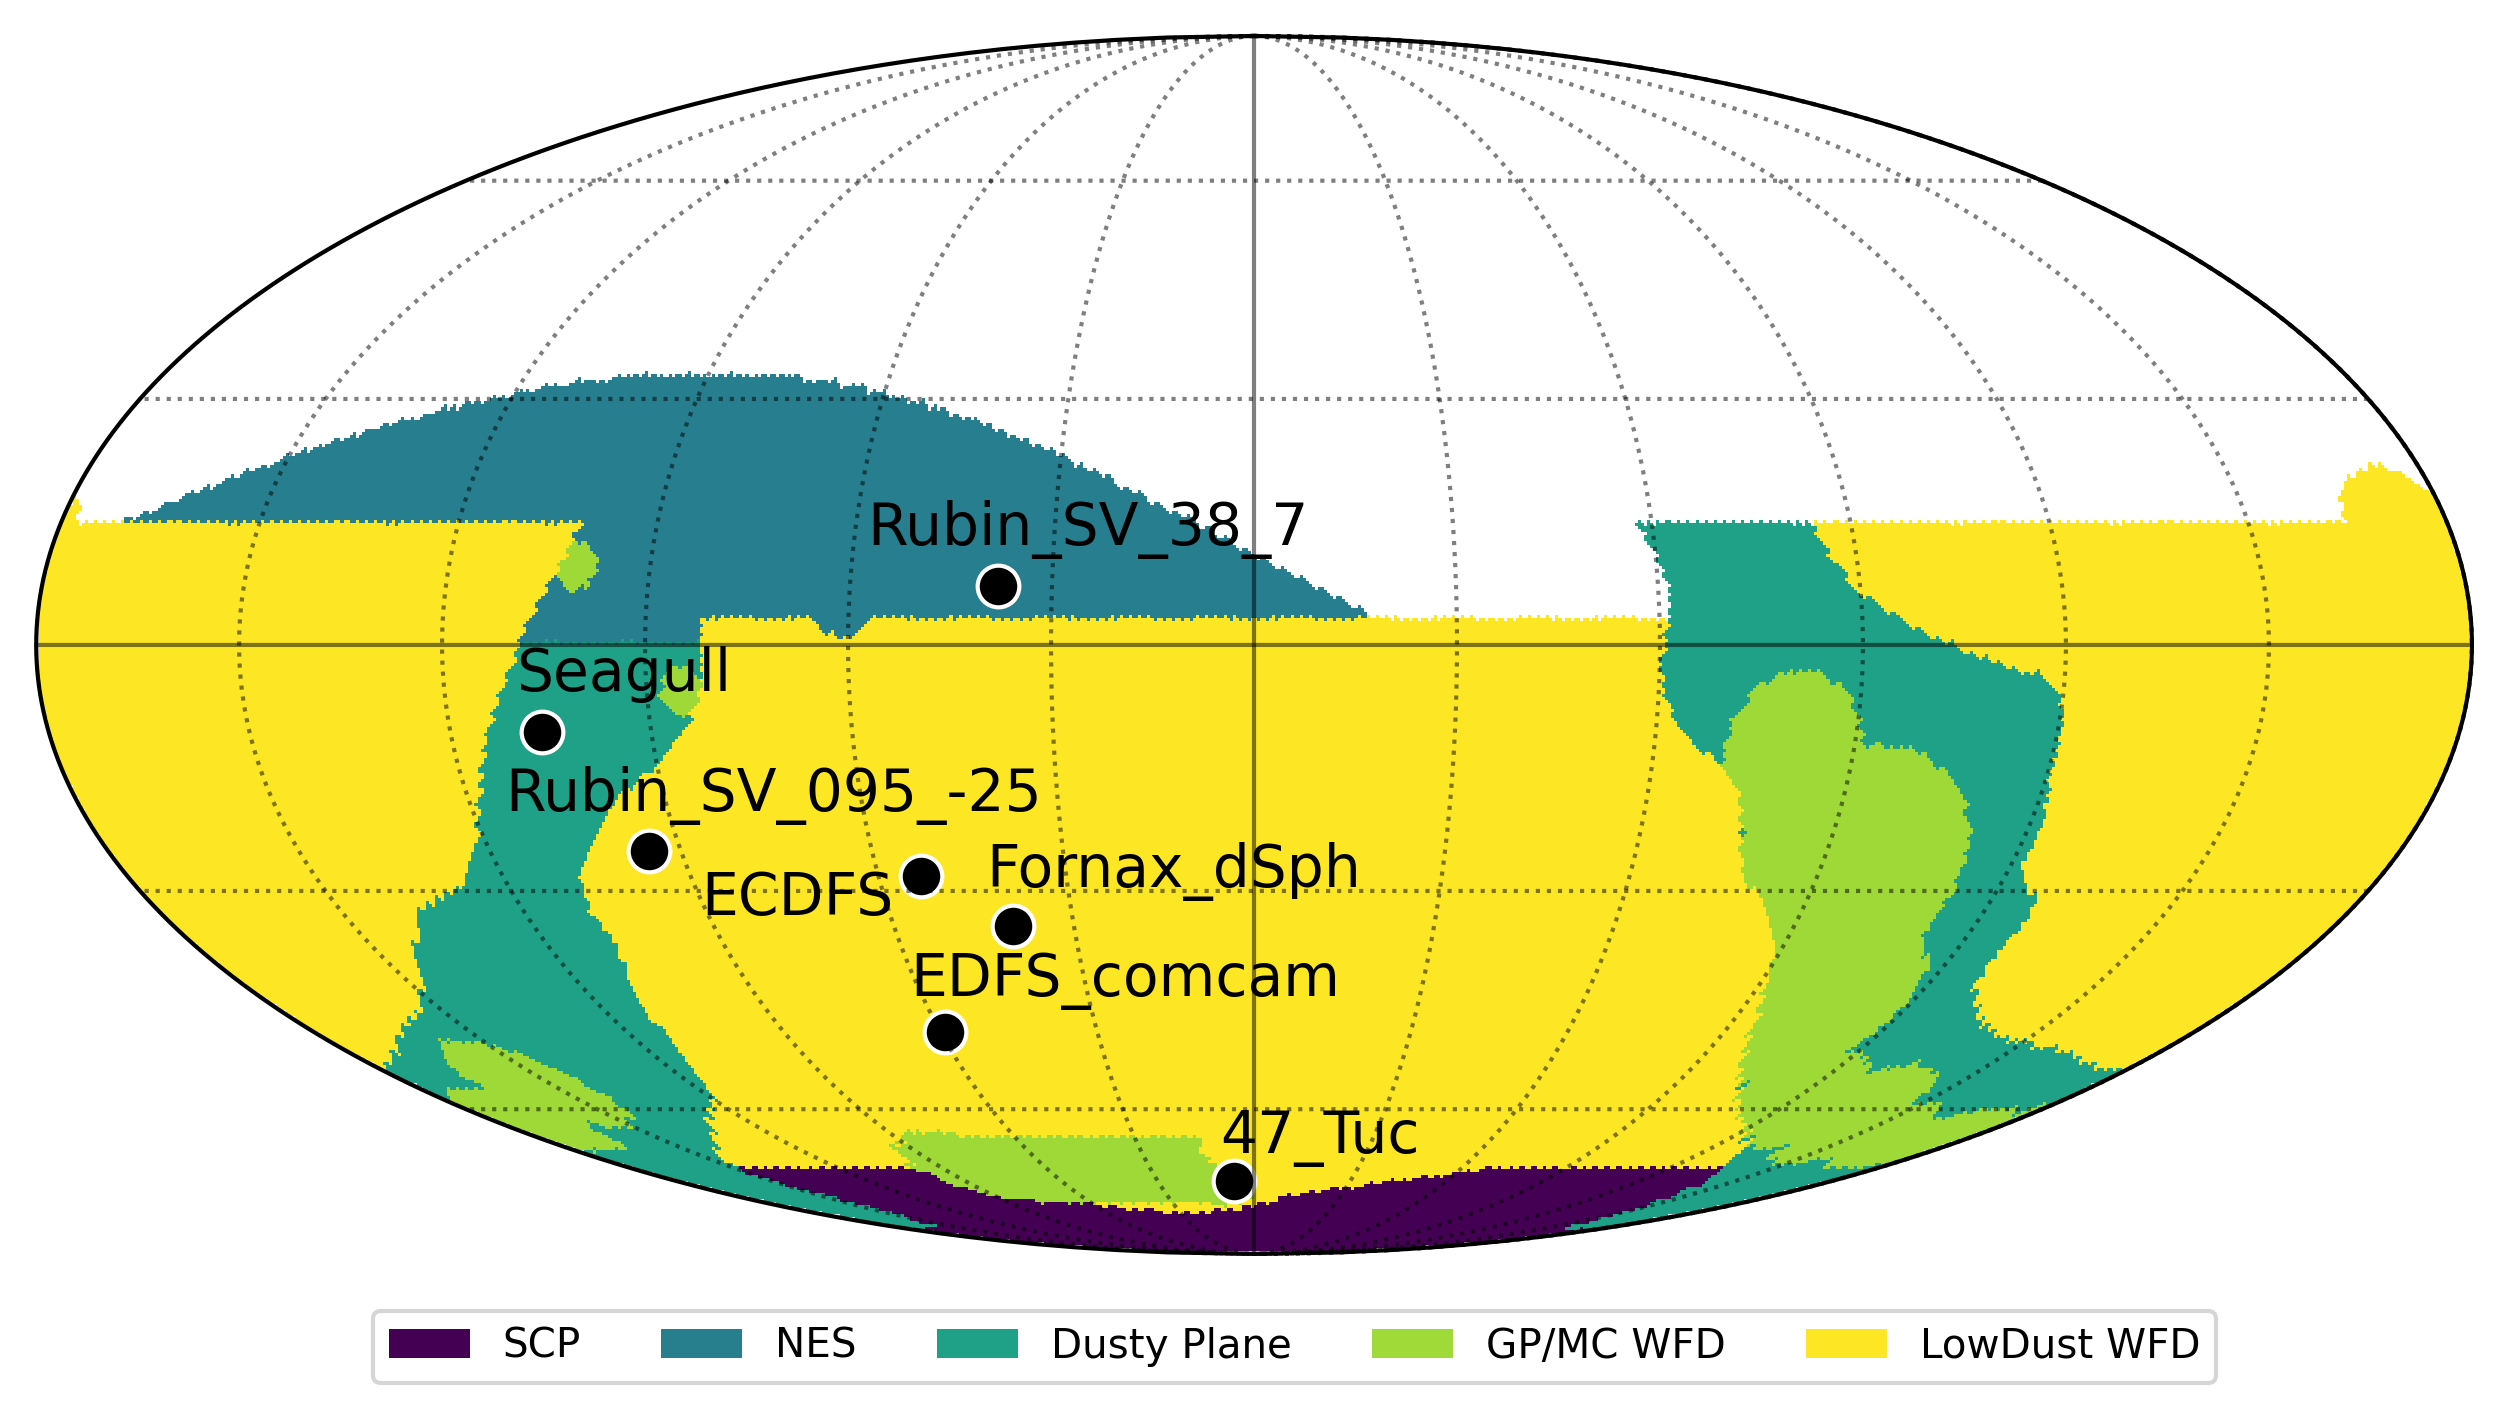

In [27]:
# Plot 
total_fp = np.zeros(len(labels))
total_fp = np.where(labels == 'scp', region_dict['scp'], total_fp)
total_fp = np.where(labels == 'nes', region_dict['nes'], total_fp)
total_fp = np.where((labels == 'dusty_plane'), region_dict['dusty_plane'], total_fp)
total_fp = np.where(((labels == 'bulgy') | (labels == 'LMC_SMC')), region_dict['gpwfd'], total_fp)
total_fp = np.where(((labels == 'euclid_overlap') | (labels == 'lowdust') | (labels == 'virgo')), region_dict['lowdust'], total_fp)
total_fp = np.where(labels == '', np.nan, total_fp)

In [ ]:
# Draw model dust map of the Milky Way Galaxy in the background.
draw_milky_way_dustmap = True

# Represent the Milky Way Galaxy by plotting a thick line along the
# Galactic equator, and two dashed lines at +/- 10 degrees.
draw_milky_way_lines = False

fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("", y=0.82)
sp = skyproj.McBrydeSkyproj(ax=ax, cellestial=True, galactic=False)
sp.ax.set_xlabel("R.A.", fontsize=14, labelpad=6)
sp.ax.set_ylabel("Dec.", fontsize=14, labelpad=14)

if draw_milky_way_dustmap:
    milkyway_filename="lambda_fds_dust_94GHz.fits"
    # Load Milky Way data as a HEALPix map (in Galactic coords)
    # Downloaded from: https://lambda.gsfc.nasa.gov/product/foreground/fg_fds_get.html
    # Model Dust Map (Finkbeiner, Davis & Schlegel)
    # Delivery Date: 2010-11-14
    with fits.open(milkyway_filename, mode='readonly') as hdu:
        mw_data = hdu[1].data["TEMPERATURE"]

    nside = hp.npix2nside(len(mw_data))
    ipix = np.arange(len(mw_data))
    theta, phi = hp.pix2ang(nside, ipix, nest=True)

    # Convert from Galactic to Equatorial.
    gal_l = np.degrees(phi)
    gal_b = 90 - np.degrees(theta)
    coords = SkyCoord(l=gal_l * u.deg, b=gal_b * u.deg, frame='galactic')
    ra = coords.icrs.ra.deg
    dec = coords.icrs.dec.deg

    theta_eq = np.radians(90 - dec)
    phi_eq = np.radians(ra)

    # Remap into HEALPix in RA/Dec.
    equatorial_mw_map = np.full_like(mw_data, hp.UNSEEN)
    remapped_pix = hp.ang2pix(nside, theta_eq, phi_eq, nest=True)
    equatorial_mw_map[remapped_pix] = mw_data

    # Interpolate values for missing (UNSEEN) pixels.
    valid = equatorial_mw_map != hp.UNSEEN
    interp_values = griddata(
        points=np.column_stack((theta_eq[valid], phi_eq[valid])),
        values=equatorial_mw_map[valid],
        xi=np.column_stack((theta_eq[~valid], phi_eq[~valid])),
        method='nearest',
    )

    # Fill in the interpolated values.
    equatorial_mw_map[~valid] = interp_values

    # Draw in RA/Dec with skyproj.
    vmin, vmax = np.nanquantile(equatorial_mw_map, (0.35, 0.99))
    sp.draw_hpxmap(equatorial_mw_map, cmap="Greys", shading="auto", nest=True, vmin=vmin, vmax=vmax, norm="log", alpha=0.7, zoom=False)

if draw_milky_way_lines:
    sp.draw_milky_way(label='Milky Way')

# Draw the survey footprint.
im, lon_raster, lat_raster, values_raster = sp.draw_hpxmap(total_fp, cmap=cmap, norm=norm, nest=False, alpha=0.6, zoom=False)

legend_elements = [Patch(facecolor=cmap(norm(region_dict['scp'])), label="SCP"),
                   Patch(facecolor=cmap(norm(region_dict['nes'])), label="NES"),
                   Patch(facecolor=cmap(norm(region_dict['dusty_plane'])), label="Dusty Plane"),
                   Patch(facecolor=cmap(norm(region_dict['gpwfd'])), label="GP/MC WFD"),
                   Patch(facecolor=cmap(norm(region_dict['lowdust'])), label="LowDust WFD")]
sp.legend(handles=legend_elements, loc=(0, 1.14), ncols=5, frameon=False)

for counter, (i, target) in enumerate(dp1_targets_summary.iterrows()):
    name = target['Field Code'].replace("\\", '')
    sign = 2 * (counter % 2) + 1
    sp.plot(target.RA, target.DEC, marker='o', color='black', markersize=4)
    x, y = sp.proj(target.RA, target.DEC)
    if name.startswith('Rubin'):
        sp.ax.text(target['RA'] + 20, target['DEC'] + 5, name, fontsize=10)
    elif name.startswith('ECDFS'):
        sp.ax.text(target['RA'] + 38, target['DEC'] - 5, name, fontsize=10)
    else:
        sp.ax.text(target['RA'] + 3, target['DEC'] + 5, name, fontsize=10)

figures_path = '.'
plt_path = os.path.join(figures_path, "dp1_fields_with_survey_fp.pdf")
plt.savefig(plt_path, format='pdf', bbox_inches='tight')

In [ ]:
plt.close()